In [233]:
import cv2
import numpy as np
import math
import scipy
import pandas as pd

## Справочные материалы

In [234]:
#справочные материалы
df_matrix = pd.DataFrame({
    'matrix': ['1', '2/3', '1/2', '1/2.5', '1/2.7', '1/2.8', '1/3', '1/4'],
    'hor': [13.54, 9.04, 6.77, 5.42, 5.02, 4.84, 4.52, 3.39],
    'vert': [10.16, 6.78, 5.08, 4.06, 3.76, 3.63, 3.39, 2.54]})


In [235]:
#справочные материалы
df_mp = pd.DataFrame({
    'Mp count': [0.02 , 0.08 , 0.1 , 0.2 , 0.4 , 0.6 , 1.0 , 1.3 , 2.0 , 2.1 , 3.1 , 4.0 , 5.0 , 6.0 , 8.3, 12.4 ],
    'width': [176.0 , 352.0 , 352.0 , 704.0 , 704.0 , 960.0 , 1280.0 , 1280.0 , 1600.0 , 1920.0 , 2048.0 , 2592.0 , 2592.0 , 2736.0 , 3840.0, 4112.0 ],
    'heigh': [120.0 , 240.0 , 288.0 , 240.0 , 480.0 , 576.0 , 720.0 , 960.0 , 1200.0 , 1080.0 , 1536.0 , 1520.0 , 1920.0 , 2192.0 , 2160.0, 3008.0]})

In [236]:
#функция расстояния между точками координат
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

## задаваемые параметры
Ниже есть варьирование по всем типам матрицы и для различных разрешений камеры. Для примера построения рассмотрим имеющуюся камеру в 12.4 Мр с форматом матрицы 1/3. За длину от камеры до объекта наблюдения примем протяженность Софийской площади. 

In [237]:
matrix='1/3'
Mp=12.4
res_opt=35 #разрешение (пиксель/метр) для мониторинга

#вспомогательные переменные(не зависят от h)
matrix_hor=df_matrix[df_matrix['matrix'] == matrix]['hor'].mean()
matrix_vert=df_matrix[df_matrix['matrix'] == matrix]['vert'].mean()
mp_width=df_mp[df_mp['Mp count'] == Mp]['width'].mean()

zone_length=haversine(31.271574, 58.522488, 31.269112, 58.523040)*1000


In [238]:
#вычисление высоты при максимальной площади 

from scipy import optimize
def f(h): 
    b_dist=np.sqrt(zone_length**2+h**2)
    focal_lenght=res_opt*matrix_hor*b_dist/mp_width
    zone_width=matrix_hor*b_dist/focal_lenght
    vert_angel=2*np.arctan(matrix_vert/(2*focal_lenght))
    r=h*np.tan(np.arctan(zone_length/h)-vert_angel)
    a_dist=np.sqrt(r**2+h**2)
    a=matrix_hor*a_dist/focal_lenght
    return 0.5*(a+zone_width)*(zone_length-r)

min_hh=scipy.optimize.minimize_scalar(lambda h: -f(h),  bounds=[1,30], method='bounded')
min_hh

     fun: -9240.1408436353267
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 15.86536253641953

## ОСНОВНЫЕ ПАРАМЕТРЫ КАМЕРЫ И ЗОНЫ НАБЛЮДЕНИЯ

In [239]:
h=min_hh.x
b_dist=np.sqrt(zone_length**2+h**2)
focal_lenght=res_opt*matrix_hor*b_dist/mp_width
zone_width=matrix_hor*b_dist/focal_lenght

hor_angle=2*np.arctan(matrix_hor/(2*focal_lenght))
vert_angel=2*np.arctan(matrix_vert/(2*focal_lenght))

tau=np.arctan(zone_length/h)-vert_angel/2 
r=h*np.tan(np.arctan(zone_length/h)-vert_angel)
a_dist=np.sqrt(r**2+h**2)
a=matrix_hor*a_dist/focal_lenght

f_long=200*matrix_hor*b_dist/mp_width

print('ОСНОВНЫЕ ПАРАМЕТРЫ КАМЕРЫ И ЗОНЫ НАБЛЮДЕНИЯ ДЛЯ МАТРИЦЫ ',matrix, 'И КАМЕРЫ В ',Mp,' МЕГАПИКСЕЛЕЙ:')
print('1) высота установки камеры ',h+1.8)
print('2) фокусное расстояние для мониторинга на горизонте (35 пикс/м): ',focal_lenght)
print('3) фокусное расстояние для распознавания на горизонте (200 пикс/м): ',f_long)
print('4) длина зоны обзора: ',zone_length)
print('5) ширина зоны обзора на горизонте: ', zone_width)
print('6) ширина фронтовой зоны обзора: ', a)
print('7) длина слепой зоны: ',r)
print('8) угол установки камеры: ', tau*57.2958)



ОСНОВНЫЕ ПАРАМЕТРЫ КАМЕРЫ И ЗОНЫ НАБЛЮДЕНИЯ ДЛЯ МАТРИЦЫ  1/3 И КАМЕРЫ В  12.4  МЕГАПИКСЕЛЕЙ:
1) высота установки камеры  17.6653625364
2) фокусное расстояние для мониторинга на горизонте (35 пикс/м):  6.01617812658
3) фокусное расстояние для распознавания на горизонте (200 пикс/м):  34.3781607233
4) длина зоны обзора:  155.56808741554195
5) ширина зоны обзора на горизонте:  117.485714286
6) ширина фронтовой зоны обзора:  19.6733731664
7) длина слепой зоны:  20.8319789261
8) угол установки камеры:  68.442269378


### Графическая интерпретация 

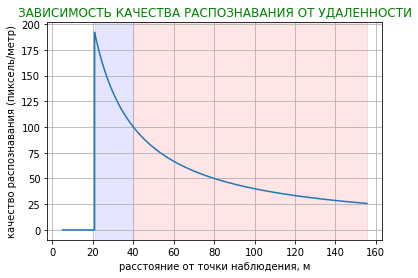

In [240]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

x_100=mp_heigh*focal_lenght/(100*matrix_hor)
x_250=mp_heigh*focal_lenght/(250*matrix_hor)

def func (x,f):
    f_width=matrix_hor*x/f
    if x>r:
        return mp_heigh/f_width
    return 0

# Интервал изменения переменной по оси X
xmin = 5
xmax = zone_length

# Шаг между точками
dx = 0.01

# Создадим список координат по оиси X  
xlist = mlab.frange (xmin, xmax, dx)

# Вычислим значение функции в заданных точках
ylist1 = [func (x,focal_lenght) for x in xlist]
#ylist2 = [func (x,4) for x in xlist]

#  Нарисуем графики
plt.plot (xlist, ylist1)
#plt.plot (xlist, ylist2)
plt.grid(True)
plt.title('ЗАВИСИМОСТЬ КАЧЕСТВА РАСПОЗНАВАНИЯ ОТ УДАЛЕННОСТИ', color='green')
plt.xlabel('расстояние от точки наблюдения, м')
plt.ylabel('качество распознавания (пиксель/метр)')
if x_250>r:
    plt.axvspan(r, x_250, color='green', alpha=0.1)
    plt.axvspan(x_250, x_100, color='blue', alpha=0.1)
    plt.axvspan(x_100, xmax, color='red', alpha=0.1)
elif x_100>r:
    plt.axvspan(r, x_100, color='blue', alpha=0.1)
    plt.axvspan(x_100, xmax, color='red', alpha=0.1)
else:
    plt.axvspan(r, xmax, color='red', alpha=0.1)
        
# Покажем окно с нарисованным графиком
plt.show()

#красная зона - обнаружение (25 пикс/метр)
#синяя зона - распознавание(100 пикс/метр)
#зеленая зона - идентификация (250 пикс/метр)

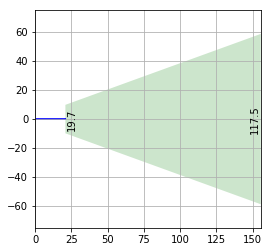

In [241]:
def drawPolygons(axes ,c):
    """
    Рисование многоугольника
    """
    polygon_1 = mpl.patches.Polygon (c,facecolor='g', alpha=0.2)
    axes.add_patch (polygon_1)
    #plt.text (0.6, -0.7, "Polygon", horizontalalignment="center")


    #polygon_2 = mpl.patches.Polygon ([c], fill = False, closed = False)
    #axes.add_patch polygon_2)
    #plt.text (-1.0, -0.1, "Polygon", horizontalalignment="center")
    return   

def drawArrow (axes,x,y,dx,dy):
    """
    Рисование стрелки
    """
    arrow = mpl.patches.FancyArrow (x,y,dx,dy, width=0.1,color="b",shape='full')
    axes.add_patch (arrow)
    return

    
area_width=150
plt.xlim (0, zone_length)
plt.ylim ((-1)*area_width/2, area_width/2)
plt.grid()

# Получим текущие оси
axes = plt.gca()
axes.set_aspect("equal")

c=[(r, a/2), (r, -1*a/2), (zone_length, -1*zone_width/2), (zone_length, zone_width/2)]
drawPolygons(axes,c)
plt.text (zone_length*0.95, 0, format(zone_width, '.1f') , rotation="vertical",verticalalignment='center')
plt.text (r*1.05, 0, format(a, '.1f') , rotation="vertical",verticalalignment='center')
drawArrow (axes,0,0,r,0)

plt.show()

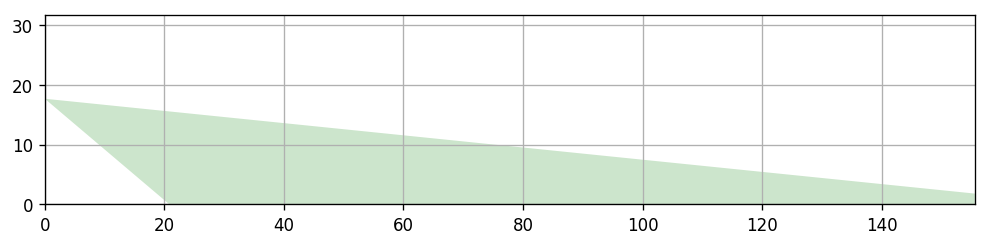

In [242]:
plt.figure(num=None, figsize=(10, 10), dpi=120)
plt.xlim (0, zone_length)
plt.ylim (0, 2*h)
plt.grid()

# Получим текущие оси
axes = plt.gca()
axes.set_aspect("equal")

c=[(0, h+1.8), (zone_length, 1.8), (zone_length, 0), (r, 0)]
drawPolygons(axes,c)
plt.show()

## Зависимость характеристик камеры и параметров зоны наблюдения от формата матрицы

In [243]:
for index, row in df_matrix.iterrows():
    
    #задаваемые параметры
    Mp=12.4
    res_opt=35#разрешение (пиксель/метр) для мониторинга

    #вспомогательные переменные(не зависят от h)
    matrix_hor=df_matrix.loc[index]['hor'].mean()
    matrix_vert=df_matrix.loc[index]['vert'].mean()
    mp_width=df_mp[df_mp['Mp count'] == Mp]['width'].mean()

    zone_length=haversine(31.271574, 58.522488, 31.269112, 58.523040)*1000

#вычисление высоты при максимальной площади 

    from scipy import optimize
    def f(h): 
        b_dist=np.sqrt(zone_length**2+h**2)
        focal_lenght=res_opt*matrix_hor*b_dist/mp_width
        zone_width=matrix_hor*b_dist/focal_lenght
        vert_angel=2*np.arctan(matrix_vert/(2*focal_lenght))
        r=h*np.tan(np.arctan(zone_length/h)-vert_angel)
        a_dist=np.sqrt(r**2+h**2)
        a=matrix_hor*a_dist/focal_lenght
        return 0.5*(a+zone_width)*(zone_length-r)

    min_hh=scipy.optimize.minimize_scalar(lambda h: -f(h),  bounds=[1,30], method='bounded')


    df_matrix.loc[index,'высота']=min_hh.x
    b_dist=np.sqrt(zone_length**2+h**2)
    df_matrix.loc[index,'фокусное расстояние для мониторинга']=res_opt*matrix_hor*b_dist/mp_width
    df_matrix.loc[index,'фокусное расстояние для распознавания']=200*matrix_hor*b_dist/mp_width
    df_matrix.loc[index,'ширина зоны охвата']=matrix_hor*b_dist/focal_lenght

    hor_angle=2*np.arctan(matrix_hor/(2*focal_lenght))
    vert_angel=2*np.arctan(matrix_vert/(2*focal_lenght))

    df_matrix.loc[index,'длина слепой зоны']=h*np.tan(np.arctan(zone_length/h)-vert_angel)
    a_dist=np.sqrt(r**2+h**2)
    df_matrix.loc[index,'ширина фонтовой линии']=matrix_hor*a_dist/focal_lenght
df_matrix

,hor,matrix,vert,высота,фокусное расстояние для мониторинга,фокусное расстояние для распознавания,ширина зоны охвата,длина слепой зоны,ширина фонтовой линии
0,13.54,1,10.16,15.924353,18.021914,102.982366,351.937295,1.059922,58.933069
1,9.04,2/3,6.78,15.865363,12.032356,68.756321,234.971429,7.525312,39.346746
2,6.77,1/2,5.08,15.924353,9.010957,51.491183,175.968647,12.574039,29.466535
3,5.42,1/2.5,4.06,15.719906,7.214090,41.223370,140.878887,16.945619,23.590638
4,5.02,1/2.7,3.76,15.708430,6.681685,38.181055,130.481922,18.556159,21.849631
5,4.84,1/2.8,3.63,15.865363,6.442102,36.812013,125.803287,19.315634,21.066178
6,4.52,1/3,3.39,15.865363,6.016178,34.378161,117.485714,20.831979,19.673373
7,3.39,1/4,2.54,15.748869,4.512134,25.783621,88.114286,27.856649,14.755030


## Зависимость характеристик камеры и параметров зоны наблюдения от разрешения камеры

In [244]:
for index, row in df_mp.iterrows():
    
    #задаваемые параметры
    Mp=12.4
    res_opt=35#разрешение (пиксель/метр) для мониторинга

    #вспомогательные переменные(не зависят от h)
    matrix_hor=df_matrix[df_matrix['matrix'] == matrix]['hor'].mean()
    matrix_vert=df_matrix[df_matrix['matrix'] == matrix]['vert'].mean()
    mp_width=df_mp.loc[index]['width'].mean()

    zone_length=haversine(31.271574, 58.522488, 31.269112, 58.523040)*1000

#вычисление высоты при максимальной площади 

    from scipy import optimize
    def f(h): 
        b_dist=np.sqrt(zone_length**2+h**2)
        focal_lenght=res_opt*matrix_hor*b_dist/mp_width
        zone_width=matrix_hor*b_dist/focal_lenght
        vert_angel=2*np.arctan(matrix_vert/(2*focal_lenght))
        r=h*np.tan(np.arctan(zone_length/h)-vert_angel)
        a_dist=np.sqrt(r**2+h**2)
        a=matrix_hor*a_dist/focal_lenght
        return 0.5*(a+zone_width)*(zone_length-r)

    min_hh=scipy.optimize.minimize_scalar(lambda h: -f(h),  bounds=[1,30], method='bounded')


    df_mp.loc[index,'высота']=min_hh.x+1.8
    b_dist=np.sqrt(zone_length**2+h**2)
    df_mp.loc[index,'фокусное расстояние для мониторинга']=res_opt*matrix_hor*b_dist/mp_width
    df_mp.loc[index,'фокусное расстояние для распознавания']=200*matrix_hor*b_dist/mp_width
    df_mp.loc[index,'ширина зоны охвата']=matrix_hor*b_dist/focal_lenght

    hor_angle=2*np.arctan(matrix_hor/(2*focal_lenght))
    vert_angel=2*np.arctan(matrix_vert/(2*focal_lenght))

    df_mp.loc[index,'длина слепой зоны']=(h+1.8)*np.tan(np.arctan(zone_length/h)-vert_angel)
    a_dist=np.sqrt(r**2+(h+1.8)**2)
    df_mp.loc[index,'ширина фонтовой линии']=matrix_hor*a_dist/focal_lenght
df_mp

,Mp count,heigh,width,высота,фокусное расстояние для мониторинга,фокусное расстояние для распознавания,ширина зоны охвата,длина слепой зоны,ширина фонтовой линии
0,0.02,120.0,176.0,2.800006,140.559798,803.198846,117.485714,23.195465,20.520964
1,0.08,240.0,352.0,2.800006,70.279899,401.599423,117.485714,23.195465,20.520964
2,0.10,288.0,352.0,2.800006,70.279899,401.599423,117.485714,23.195465,20.520964
3,0.20,240.0,704.0,2.800006,35.139950,200.799711,117.485714,23.195465,20.520964
4,0.40,480.0,704.0,2.800006,35.139950,200.799711,117.485714,23.195465,20.520964
5,0.60,576.0,960.0,2.800006,25.769296,147.253122,117.485714,23.195465,20.520964
6,1.00,720.0,1280.0,2.800006,19.326972,110.439841,117.485714,23.195465,20.520964
7,1.30,960.0,1280.0,2.800006,19.326972,110.439841,117.485714,23.195465,20.520964
8,2.00,1200.0,1600.0,2.800006,15.461578,88.351873,117.485714,23.195465,20.520964
9,2.10,1080.0,1920.0,2.800006,12.884648,73.626561,117.485714,23.195465,20.520964


### пометки

#Задачи
1) прописать ограничения для всех переменных
2) составить и нарисовать графики зависимости качества от длины зоны распознавания при разных параметрах: фокуса, Мр
3) наприсать функцию: максимум площади при ограничении на качество распознавания 
4) нарисовать все

изымать данные высоты и ширины из таблички типов матриц. Поиск по размеру матрицы или расширению (1 или 1/3) 
http://infotech.com.ua/article/standarty-identifikacii-raspoznavanii-i-detektirovanii-ludei

уравнения
http://www.osc.phys.msu.ru/mediawiki/upload/Khalili/optimize.pdf

про скорость
http://sio.su/down_a4ud_305_def.aspx

про старые камеры и угол от высоты
https://studbooks.net/2353623/tehnika/raschet_obzora_videokamer

про программу, которая все уже делает
https://markevich.by/obuchenie-proektirovaniyu/urok-2-zony-obzora-kamer-videonablyudeniya.html





Разрешение видеокамеры https://rucam-video.ru/baza_znanij/razreshenie-kamer-videonablyudeniya-chto-ehto.html 

все про матрицу, таблица размеров https://ru.wikipedia.org/wiki/Фотоматрица

характеристики популярных камер
https://vt-tech.eu/articles/foto/277-tablitsa-kharakteristik-matrits-tsifrovykh-fotoapparatov.html

калькулятор и таблица матриц https://www.ivtechno.ru/raschet_6

про программы существующие https://algoritm.org/arch/13_1/13_1_3.pdf

Дипломная работа про камеры https://sibsutis.ru/upload/f33/Кобер_ВКР_v5.9.pdf 

фигуры на графике https://jenyay.net/Matplotlib/Figures

пиксель на метр http://lsv-tech.ru/vychisleniye-plotnosti-pikseley/ 